In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image


print("Torch version:", torch.__version__)


/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0+cu117


In [3]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/

In [4]:
# !mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/

### Load Hateful Meme Dataset

In [5]:
import pandas as pd
import os

HOME = os.environ.get("HOME")
images_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
annotations_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)


In [6]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [7]:
# Collect all the annotations (from Phase-2)
train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets: 
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ['train', 'dev_seen', 'dev_unseen', 'test_seen', 'test_unseen']
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(f"\nIn total there are {total_size} images,",
          "\nBut the # of images in /img/ directory is: ", len(a))

#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [8]:
print("#of images that are not in one of the .jsonl files: ", 
      len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))))

#of images that are not in one of the .jsonl files:  329


In [9]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}")

#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [10]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(f"{annotations_path}/train_updated.jsonl", orient="records", lines=True)
train.shape, train_updated.shape

((8500, 4), (8600, 4))

## Write the dataloader class

In [11]:
train.head(1)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [12]:
class HMDataset(Dataset):
    def __init__(self, images_path: str, annotation_path: str, image_transform=None, text_transform=None) -> None:
        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(".jsonl"), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)      

    def __len__(self):
        return self.annotation.shape[0]

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path, self.annotation.loc[idx,"img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[idx,"text"]
        label = self.annotation.loc[idx,"label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, label

In [13]:
hm_dataloader = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", )
len(hm_dataloader)

8600

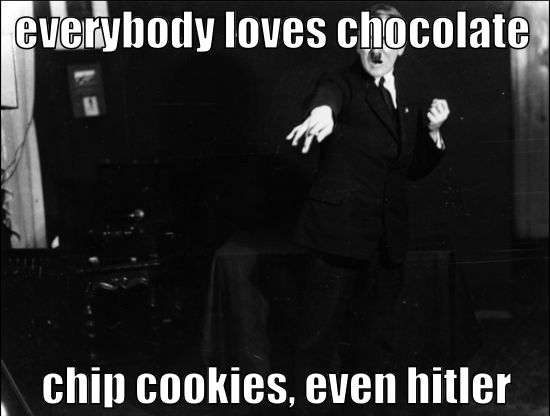

In [14]:
hm_dataloader[0][0]

In [15]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [17]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f83c4383f40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [18]:
clip.tokenize("This is awesome really")

tensor([[49406,   589,   533,  1848,  1414, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [19]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

In [20]:
np.random.random_integers(0, len(hm_dataloader), 8)

/tmp/ipykernel_1354617/1391141764.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  np.random.random_integers(0, len(hm_dataloader), 8)


array([8234, 7991, 7928, 5062, 7450, 4194, 6549, 1075])

/tmp/ipykernel_1354617/2821440428.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):


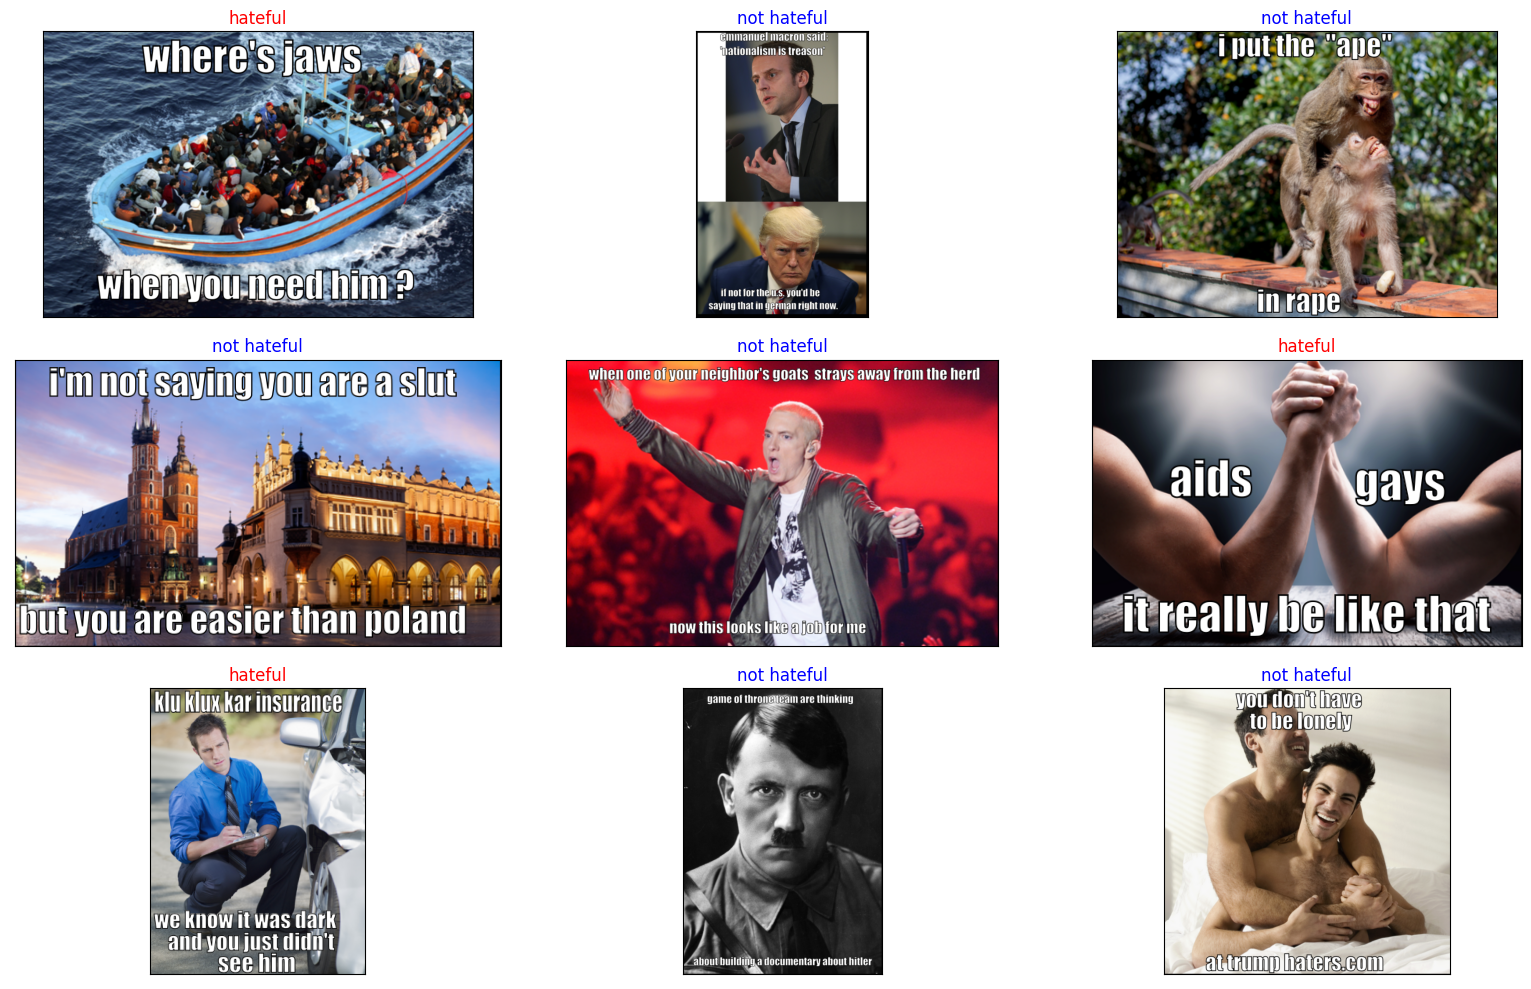

In [21]:
hm_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None)

plt.figure(figsize=(16, 10))

label_map = {1:"hateful", 0:"not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i+1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class HMMLP(nn.Module):

    def __init__(self, f_input=512*2, classes=2, ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(f_input, classes)
        # self.fc2 = nn.Linear(256, 64)
        # self.fc3 = nn.Linear(64, 16)
        # self.fc4 = nn.Linear(16, classes)

    def forward(self, x):
        
        x = self.fc1(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = self.fc4(x)

        return x

In [23]:
batch_size = 4

hm_train_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=preprocess, text_transform=clip.tokenize)
hm_test_dataset = HMDataset(images_path, f"{annotations_path}/test_unseen.jsonl", image_transform=preprocess, text_transform=clip.tokenize)
hm_val_dataset = HMDataset(images_path, f"{annotations_path}/dev_unseen.jsonl", image_transform=preprocess, text_transform=clip.tokenize)

train_dataloader = DataLoader(hm_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True)

In [24]:
data = next(iter(train_dataloader))

In [25]:
net = HMMLP()
images, texts, labels = data
images = images.to("cuda")
texts = texts.to("cuda")
labels = F.one_hot(labels.to("cuda"), num_classes=2).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())


In [26]:
net = net.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [27]:
fused = torch.hstack((images,texts))
fused.requires_grad

False

In [28]:
fused.requires_grad_()
fused.requires_grad

True

In [29]:
output = net(fused.float())

In [36]:
output.min()

RuntimeError: numel: integer multiplication overflow

In [30]:
loss = criterion(output, labels)
loss.backward()

../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [6,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [34]:
net = HMMLP()
net = net.cuda()

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        print(i)
        images, texts, labels = data
        images = images.to("cuda")
        texts = texts.to("cuda")
        labels = F.one_hot(labels, num_classes=2).float().to("cuda")

        with torch.no_grad():
            images = model.encode_image(images) # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(texts.squeeze()) # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        fused_images_texts = torch.hstack((images,texts))
        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        output = net(fused_images_texts)

        loss = criterion(output, labels)

        # Compute gradient
        loss.backward()
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i%50==49:
            print(f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/50:.3f}")
            running_loss = 0.0

print("Finished Training!")
        

0


RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR